![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Se observa que existe una diferencia notable en la cantidad de vajes medios por casa season dentro del año. El invierno (Temporada 1) tiene la menor cantidad de viajes promedio, mientras que el verano (temporada 3) tiene la mayor cantidad de viajes promedio.

Estas diferencias nos permiten inferir que será necesario incorporar esta variable de manera codificada, dado que la variable no muestra linealidad en la relación de ambas variables, lo cual responde al hecho que es una variable categorica. Una estrategía debería ser aplicar un one hot encoder.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

La distribución de la cantidad promedio de viajes en bicicleta a lo largo del día muestra un patrón distintivo de picos y valles. Las horas tempranas de la mañana, especialmente entre las 6:00 AM y las 9:00 AM, y luego nuevamente en la tarde, alrededor de las 5:00 PM exhiben los niveles más altos de actividad, sugiriendo una fuerte correlación con los desplazamientos laborales.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

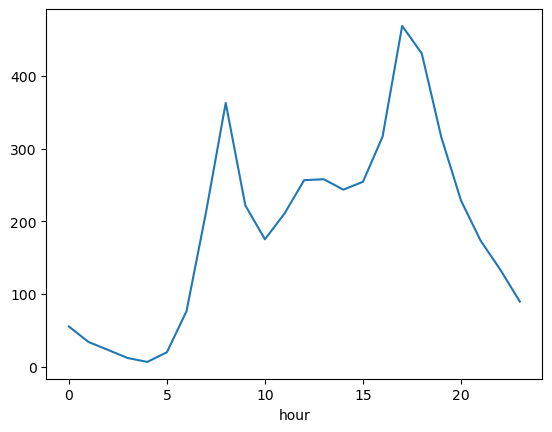

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

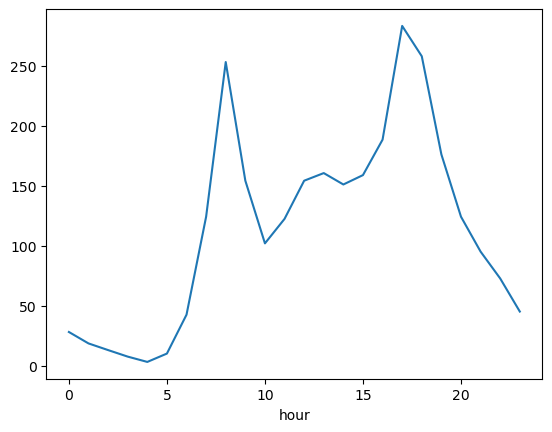

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes[bikes['season'] == 1].groupby('hour').total.mean().plot()

Podemos observar que existe un patrón muy similar al año en general, las horas picos son alrededor de las 8 y 9 AM, el segundo pico es a las 5 y 6 PM y la cantidad de viajes caen en las horas de la madrugada y empiezan a repuntar a las 5 de mañana. Además, podemos observar que no existe una relación líneal, por tanto, los algoritmos de regresión mediante parámetros lineales no obtendran resultados óptimos.

<Axes: xlabel='hour'>

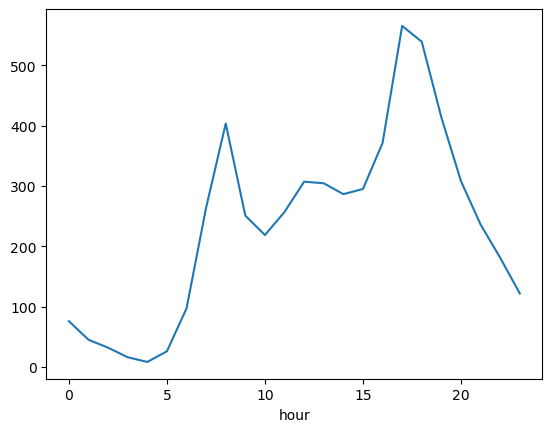

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes[bikes['season'] == 3].groupby('hour').total.mean().plot()

Para la estación de verano los resultados no presentan ningún cambio de estructura, lo destacable en diferencia con el invierno es la magnitud viste en el eje y de cantidad de viajes, en el verano se observa claramente que la cantidad de viajes es mucho mayor que en invierno, posiblemente producto de un mejor clima para la actividad al aire libre.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [123]:
# Celda 3

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

X = bikes[['hour','season']]
y = bikes['total']

encoder = OneHotEncoder(sparse=False)
encoded_season = encoder.fit_transform(X[['season']])

encoded_df = pd.DataFrame(encoded_season, columns=encoder.get_feature_names_out(['season']))

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

X_encoded = pd.concat([X.drop('season', axis=1), encoded_df], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_pred_lr, y_test)

print('Error de la regresión lineal:')
print(mse_lr)

print("Coeficientes de la regresión lineal:")
for coef, nombre_variable in zip(lr.coef_, X_encoded.columns):
    print(f"{nombre_variable}: {coef}")


Error de la regresión lineal:
25592.233069213817
Coeficientes de la regresión lineal:
hour: 10.727042004115185
season_1: -75.93875968128515
season_2: 23.819732556605963
season_3: 39.13958079897668
season_4: 12.97944632570247


Por el lado de las variables dummy vemos resultados esperados, se observa claramente que la dummy que señala la estación de invierno tiene un coeficiente negativo y alto en magnitud, mientras el coeficiente de la estación de verano tiene la mayor magnitud de las variables positivas.

En cuanto al coeficiente de la hora observamos un coeficiente positivo, es decir, a mayor cantidad de horas mayor cantidad de viajes. Sin embargo, la gráfica de la variable mostraba entre las estaciones el comportamiento no lineal de las horas en la cantidad de viajes. Esto nos lleva a pensar que existe un potencial problema de underfitting en el modelo, producto de la incapacidad del modelo de capturar estas relaciones complejas.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [119]:
# Celda 4
def mse(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y[filter_l]
    y_r = y[filter_l]
    
    y_l_mean = y_l.mean()
    y_r_mean = y_r.mean()
    
    y_l_mean_vector = np.repeat(y_l_mean, len(y_l))
    y_r_mean_vector = np.repeat(y_r_mean, len(y_r))
    
    mse_ = (mean_squared_error(y_l_mean_vector, y_l) + mean_squared_error(y_r_mean_vector, y_r))/2
    
    return mse_


def best_split(XX, y, num_pct=10):
    features = range(XX.shape[1])
    best_split = [0, 0, np.float('Inf')]  # j, split, error
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(XX.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        for split in splits:
            error = mse(XX.iloc[:, j], y, split)
            if error < best_split[2]:
                best_split = [j, split, error]
    
    return best_split



def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, mse=0)
        return tree
    
    global_error = mean_squared_error(np.repeat(y.mean(), len(y)), y)
    # Calcular la mejor división
    j, split, error = best_split(X, y, num_pct)
    
    gain = (global_error - error/2)/global_error
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=error)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree



def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [120]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 191.37034120734907,
 'level': 0,
 'split': [0, 6.0],
 'n_samples': 7620,
 'mse': 872.5444705827347,
 'sl': {'y_pred': 24.950469238790408,
  'level': 1,
  'split': [3, 1.0],
  'n_samples': 1918,
  'mse': 677.0146643168129,
  'sl': {'y_pred': 22.000698324022345,
   'level': 2,
   'split': [4, 1.0],
   'n_samples': 1432,
   'mse': 573.6935866130423,
   'sl': {'y_pred': 19.872881355932204,
    'level': 3,
    'split': -1,
    'n_samples': 944,
    'mse': 331.91464821222604},
   'sr': {'y_pred': 26.116803278688526,
    'level': 3,
    'split': -1,
    'n_samples': 488,
    'mse': 1000.662707321472}},
  'sr': {'y_pred': 33.641975308641975,
   'level': 2,
   'split': [0, 5.0],
   'n_samples': 486,
   'mse': 1575.489855857742,
   'sl': {'y_pred': 35.10669975186104,
    'level': 3,
    'split': -1,
    'n_samples': 403,
    'mse': 1743.1036841226005},
   'sr': {'y_pred': 26.53012048192771,
    'level': 3,
    'split': -1,
    'n_samples': 83,
    'mse': inf}}},
 'sr': {'y_pred': 247.

In [121]:
y_pred_tree_manual = tree_predict(X_test, tree)
y_pred_tree_manual

array([260.1581854 ,  70.75103734, 260.1581854 , ..., 260.1581854 ,
       260.1581854 ,  19.87288136])

In [122]:
print('Error cuadrático medio del árbol manual:')
mse_manual_tree = mean_squared_error(y_pred_tree_manual, y_test)
print(mse_manual_tree)

Error cuadrático medio del árbol manual:
22724.60790381352


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [76]:
# Celda 5

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = tree_reg.predict(X_test)

# Calcular el error cuadrático medio (MSE)
mse_tree = mean_squared_error(y_test, y_pred)
print(f'Error cuadrático medio del árbol con libreria:')
mse_tree

Error cuadrático medio del árbol con libreria:


18096.321227594133

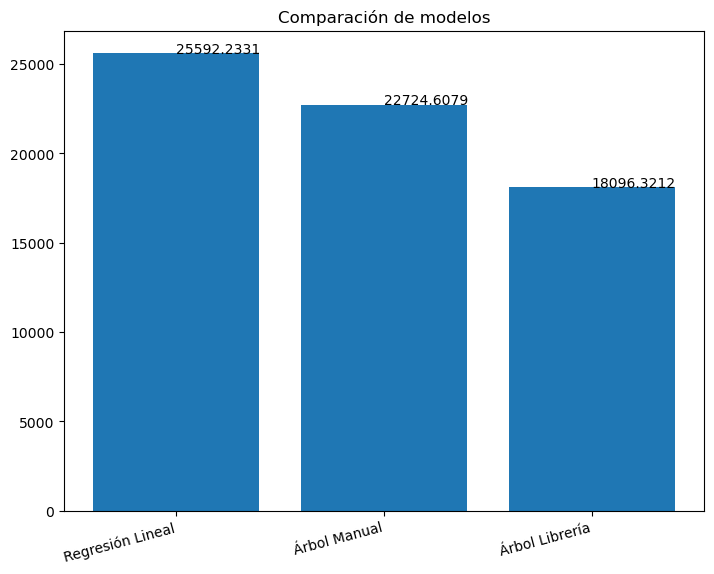

In [124]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Regresión Lineal','Árbol Manual' ,'Árbol Librería']
ejeY = [mse_lr, mse_manual_tree, mse_tree]

ejeY_rounded = [round(error, 4) for error in ejeY]
plt.xticks(rotation=15, ha='right')

ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY_rounded,plt)
plt.show()

Dada la no linealidad de las variables regresoras ante el target el modelo de regresión lineal es el modelo con el error más alto alcanzando un MSE de 25.592. El modelo de arboles manuales tiene un desempeño superior al modelo de regresión lineal con un MSE de 22.724, lo cual representa una mejora significativa en la reducción del error.

Finalmente, el modelo de arbol usando la librería sklearn es el modelo con menor MSE (18.096), el mejor desempeño del árbol con librería se puede explicar con el mecanismo de busqueda de cortes, dado que el arbol manual se limita a testear los cortes solo mediante deciles mientras el arbol de la librería hace una busqueda más exhaustiva. Ambos arboles presentados tienen la misma condición de finalización de una profundidad máxima de 3 niveles, es decir, entre 6 y 8 nodos finales. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [109]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [110]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [111]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [112]:
# Celda 6
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = log_reg.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1}')

Accuracy: 0.6146666666666667
F1-score: 0.6110363391655451


In [115]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

tree_clf = DecisionTreeClassifier()

# Definir la grilla de parámetros para la búsqueda
param_grid = {'max_depth': range(1, 10), 'criterion': ['gini', 'entropy']}  # Prueba profundidades de árbol de 1 a 10

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X, y)

# Obtener los mejores resultados de la búsqueda
print("Mejores parámetros:", grid_search.best_params_)
accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))

print("Mejor puntaje F1:", grid_search.best_score_)
print("Mejor puntaje Accuracy:", accuracy)

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4}
Mejor puntaje F1: 0.6447887963953747
Mejor puntaje Accuracy: 0.6553333333333333


El modelo del árbol de decisión obtuvo un mejor desempeño que el modelo de la regresión logística. En concreto, el modelo de árbol de decisión obtuvo una tasa de acierto del 0.655 mientras que el modelo de regresión logística alcanzó una tasa de acierto del 0.615.

Los hiperparametros validados en el árbol de decisión fueron el criterio de separación y creación de nodos y la profundidad máxima del arbol.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [106]:
# Celda 7


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generar datos de ejemplo
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar y evaluar árboles de decisión con max_depth
tree_clf_max_depth = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100)
tree_clf_max_depth.fit(X_train, y_train)
y_pred_tree_max_depth = tree_clf_max_depth.predict(X_test)
acc_tree_max_depth = accuracy_score(y_test, y_pred_tree_max_depth)
f1_tree_max_depth = f1_score(y_test, y_pred_tree_max_depth)

# Entrenar y evaluar árboles de decisión con min_samples_leaf
tree_clf_min_samples_leaf = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=10), n_estimators=100)
tree_clf_min_samples_leaf.fit(X_train, y_train)
y_pred_tree_min_samples_leaf = tree_clf_min_samples_leaf.predict(X_test)
acc_tree_min_samples_leaf = accuracy_score(y_test, y_pred_tree_min_samples_leaf)
f1_tree_min_samples_leaf = f1_score(y_test, y_pred_tree_min_samples_leaf)

# Entrenar y evaluar regresión logística
log_reg = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Crear ensamble con la metodología de Votación Mayoritaria
ensemble = VotingClassifier(estimators=[
    ('tree_max_depth', tree_clf_max_depth),
    ('tree_min_samples_leaf', tree_clf_min_samples_leaf),
    ('logistic_regression', log_reg)
], voting='hard')
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)

# Imprimir resultados
print("Resultados para árboles de decisión con max_depth:")
print("Accuracy:", acc_tree_max_depth)
print("F1-score:", f1_tree_max_depth)
print("\n")
print("Resultados para árboles de decisión con min_samples_leaf:")
print("Accuracy:", acc_tree_min_samples_leaf)
print("F1-score:", f1_tree_min_samples_leaf)
print("\n")
print("Resultados para regresión logística:")
print("Accuracy:", acc_log_reg)
print("F1-score:", f1_log_reg)
print("\n")
print("Resultados para el ensamble:")
print("Accuracy:", acc_ensemble)
print("F1-score:", f1_ensemble)


Resultados para árboles de decisión con max_depth:
Accuracy: 0.87
F1-score: 0.8807339449541284


Resultados para árboles de decisión con min_samples_leaf:
Accuracy: 0.885
F1-score: 0.892018779342723


Resultados para regresión logística:
Accuracy: 0.825
F1-score: 0.8372093023255813


Resultados para el ensamble:
Accuracy: 0.87
F1-score: 0.8807339449541284


Se entrenaron 4 configuraciones de modelos, se seleccionaron los hiperparametros **max_depth = 3** y **min_samples_leaf = 10** para cada uno de los modelos basados en arboles. Por otro lado, se incorporó un bagging con regresiones logisticas. Los modelos de bagging sin stacking obtuvieron un accuracy superior al 0.80.

Por el lado del modelo de ensamble con votación de los 3 bagging, el desempeño no supera el el bagging individual de mejor desempeño (modelo de arboles con min_samples_leaf = 10). Esto puede ser debido a la ponderación homogenea de la votación. 

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [101]:
from sklearn import metrics
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
all_samples = tree_clf_max_depth.estimators_samples_ + tree_clf_min_samples_leaf.estimators_samples_ + log_reg.estimators_samples_
all_estimators = tree_clf_max_depth.estimators_ + tree_clf_min_samples_leaf.estimators_ + log_reg.estimators_

errors = np.zeros(len(all_samples))
y_pred_all_ = np.zeros((X_test.shape[0], len(all_samples)))

for i in range(len(all_samples)):
    oob_sample = ~all_samples[i]
    y_pred_ = all_estimators[i].predict(X_train[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train[oob_sample])
    y_pred_all_[:, i] = all_estimators[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

f1_weigthed_voting = metrics.f1_score(y_pred, y_test)
acc_weigthed_voting = metrics.accuracy_score(y_pred, y_test)

acc_weigthed_voting, f1_weigthed_voting

(0.855, 0.8651162790697674)

Se utilizó un modelo compuesto de votación utilizando los 300 modelos individuales añadidos mediante un proceso de votación ponderada, el cual pondera los pesos de la regresión el parámetro del error (alpha). El parámetro alpha fue estimado en concreto con el error de las muestras OOB.


El modelo muestra un desempeño acorde a los modelos previos con un **Accuracy de 0.855** y un **F1 de 0.865**

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

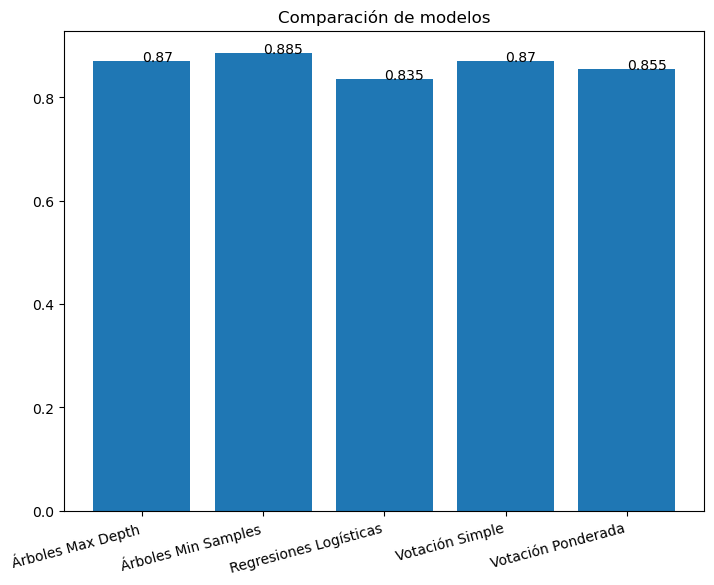

In [104]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['Árboles Max Depth','Árboles Min Samples' ,'Regresiones Logísticas','Votación Simple', 'Votación Ponderada']
ejeY = [acc_tree_max_depth,acc_tree_min_samples_leaf,acc_log_reg,acc_ensemble,acc_weigthed_voting]

ejeY_rounded = [round(error, 4) for error in ejeY]
plt.xticks(rotation=15, ha='right')

ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY_rounded,plt)
plt.show()

Los resultados de los modelos muestran un mejor desempeño en el algoritmo de votación de árboles controlados por *Min Samples Leaf*. Por otro lado, los modelos de votación por stacking (simple y ponderado) de los modelos de baggin, no muestran, en este caso particular, un mejor resultado de accuracy. El modelo con el peor desempeño es el modelo bagging con regresiones logísticas. 

El hecho que los modelos basados en arboles de decisión tengan mejores métricas que el modelo de bagging con regresiones logisticas nos lleva a plantear el hecho de que existen relaciones no lineales entre los regresores y el target.